In [1]:
%%writefile /scratch/users/vxue/data/sort_specificity/rmse_doubleSet/ncv_y/bootstrap_4381.py

import sys
import numpy as np
print(sys.version)
import re
from sklearn import svm
from operator import itemgetter
from sklearn import cross_validation
from sklearn.cross_validation import KFold
import pickle
import scipy.stats
import pandas as pd
import scipy as sp
import os
import seaborn as sb


myDataSets,myDataSetName = pickle.load(open('/home/vxue/data/sort_specificity/ncv_y/allData.pickle','rb'))


myCValues=dict()

myCValues['linear'] = [
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
            ]
myCValues['poly'] = [
             [2**i for i in range( -14 , 3 )],                                  
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
            ]


myWeights = [False] * 12

epsilon = np.arange(0.00,1,0.05)





#Define Dummy Variable Encoding
aminoAcidIndex = 'ACEDGFIHKMLNQPSRTWVY'

def getAAVector(letter):
    vector = np.zeros(20);
    vector[aminoAcidIndex.index(letter)]=1
    return  vector

def encodeWithDummyVariables(sequence):
    newArray=[]
    for aa in sequence:
        newArray.append(getAAVector(aa))
    return np.array(newArray).ravel()

def encodeWithDummyVariables_six(sequence):
    newArray=[]
    for idx,aa in enumerate(sequence):
        if(idx in [6,10,11,13,15,17]):
            newArray.append(getAAVector(aa))
        else:
            newArray.append(np.zeros(20))
    return np.array(newArray).ravel()
def encodeWithDummyVariables_seven(sequence):
    newArray=[]
    for idx,aa in enumerate(sequence):
        if(idx in [0,6,10,11,13,15,17]):
            newArray.append(getAAVector(aa))
        else:
            newArray.append(np.zeros(20))
    return np.array(newArray).ravel()





for each,name in zip(myDataSets,myDataSetName):
    if(re.search("bg",name)):
        print("bg",end=' ')
        each['aaEncoding'] = each.apply(lambda x: list(encodeWithDummyVariables_seven(x.twentytwo)),axis=1)
        print(sum(each.iloc[0]['aaEncoding']))
    elif(re.search("strict",name)):
        print("strict",end=' ')
        each['aaEncoding'] = each.apply(lambda x: list(encodeWithDummyVariables_six(x.twentytwo)),axis=1)
        print(sum(each.iloc[0]['aaEncoding']))
    else:
        print("normal",end =' ')
        each['aaEncoding'] = each.apply(lambda x: list(encodeWithDummyVariables(x.twentytwo)),axis=1)
        print(sum(each.iloc[0]['aaEncoding']))

        
myModel =svm.SVR(kernel='linear',degree=2,gamma=1,coef0=0) 

def nestedCV(uniqueSlurmCode, seed,topFoldToWorkOn,mode,dataset, datasetName, hasWeights, cValues):
    
    with open("/home/vxue/data/sort_specificity/rmse_doubleSet/ncv_y/"+str(seed)+"."+mode+"."+datasetName+"."+str(topFoldToWorkOn),'w') as myCV:
    
        kfoldTop = cross_validation.KFold(len(dataset),10,True,seed)

        myTopFoldCount = 0
        for train_index_top, validate_index_top in kfoldTop:

            if(topFoldToWorkOn==myTopFoldCount):
                    
                    myCV.write(str(uniqueSlurmCode) + " " + str(len(dataset)) + " " + datasetName+ "\n")
                    myCV.write("topFold cParam epsilonParam train test validate \n")

                    trainData = dataset.loc[train_index_top]
                    validateData = dataset.loc[validate_index_top]

                    validateData_matrix_all = np.array([np.array(i) for i in validateData.aaEncoding.get_values()])
                    validateData_y_all = np.array(validateData.yValue)

                    trainData_matrix_all = np.array([np.array(i) for i in trainData.aaEncoding.get_values()])
                    trainData_y_all = np.array(trainData.yValue)

                    trainData_w_all=None
                    if(hasWeights):
                        trainData_w_all = np.array(trainData.unnormalized_weights)



                    epsilonValues= epsilon

                    for paramC in cValues:
                        for paramEpsilon in epsilonValues:        

                            myCV.write(str(myTopFoldCount))
                            myCV.write(" ")
                            myCV.write(str(paramC))
                            myCV.write(" ")
                            myCV.write(str(paramEpsilon))
                            myCV.write(" ")
                            myCV.flush()

                            myModel.set_params(kernel=mode, C=paramC,epsilon=paramEpsilon)
                            clf = myModel

                            ########################### Second round of k-fold 

                            kfold = cross_validation.KFold(len(trainData_y_all),10,True,26)
                            scores_test = []
                            scores_train = []
                            scores_validate = []

                            for train_index, test_index in kfold:

                                X_train= trainData_matrix_all[train_index]
                                y_train= trainData_y_all[train_index]
                                w_train = None
                                if(hasWeights==True):
                                    w_train= trainData_w_all[train_index]
                                    w_train = w_train / sum(w_train)

                                clf.fit(X_train,y_train,sample_weight=w_train)

                                X_test = trainData_matrix_all[test_index]
                                y_test = trainData_y_all[test_index]

                                X_validate = validateData_matrix_all
                                y_validate = validateData_y_all

                                scores_test.append(clf.score(X_test,y_test))
                                scores_train.append(clf.score(X_train,y_train))
                                scores_validate.append(clf.score(X_validate,y_validate))
                                
                                #scores_test.append(0)
                                #scores_validate.append(0)
                                #scores_train.append(0)
                                
                                print(".",end='')
                            print("")


                            for value in [np.mean(scores_train),np.mean(scores_test),np.mean(scores_validate)]:
                                myCV.write(str(value))
                                myCV.write(" ")
                            myCV.write("\n")
                            ########################### Second round of k-fold

            myTopFoldCount+=1                

            
#############################################################
seed=1
slurmInput = int(sys.argv[1])    
#############################################################

myDistributedCounter = 0 
for mode in ['linear','poly']:
    for dataset, datasetName, hasWeights, cValues in zip(myDataSets, myDataSetName, myWeights, myCValues[mode]):

        for topFold in range(10): 
            if(myDistributedCounter==slurmInput): #I want to distribute the top fold to each core
                print(myDistributedCounter,mode,datasetName,topFold)
                nestedCV(slurmInput,seed,myDistributedCounter%10,mode,dataset, datasetName, hasWeights, cValues)
            myDistributedCounter+=1

Writing /scratch/users/vxue/data/sort_specificity/rmse_doubleSet/ncv_y/bootstrap_4381.py


In [1]:
import sys
import numpy as np
print(sys.version)
import re
from sklearn import svm
from operator import itemgetter
from sklearn import cross_validation
from sklearn.cross_validation import KFold
import pickle
import scipy.stats
import pandas as pd
import scipy as sp
import os
import seaborn as sb


myDataSets,myDataSetName = pickle.load(open('/home/vxue/data/sort_specificity/ncv_y/allData.pickle','rb'))

myCValues=dict()

myCValues['linear'] = [
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
             [2**i for i in range( -10 , 6 )],
            ]
myCValues['poly'] = [
             [2**i for i in range( -14 , 3 )],                                  
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
             [2**i for i in range( -14 , 3 )],
            ]



myWeights = [False] * 12

epsilon = np.arange(0.00,1,0.05)


3.5.1 |Continuum Analytics, Inc.| (default, Dec  7 2015, 11:16:01) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
%pylab inline
plt.close()
topFold=1

Populating the interactive namespace from numpy and matplotlib


In [3]:
def plotGridSearch(directory,cvalue,epsilon,datasetName):
    
        figure(figsize=(14,10))
        oneRound = []
        oneRoundValidate = []
        for j in range(10): #outerloop
            myPdArray = pd.read_csv(directory+str(j),delimiter="\s+",skiprows=1)
            
            totSize = len(cvalue)*len(epsilon)
            expandedArray = np.array(myPdArray['test'])
            oneRound.append(np.nan_to_num(np.concatenate([expandedArray, np.array([np.nan]*(totSize - len(expandedArray)))]).reshape(len(cvalue),len(epsilon))))
            
            #oneRound.append(np.array(myPdArray['test']).reshape(25,13))
            
            expandedArray = np.array(myPdArray['validate'])
            oneRoundValidate.append(np.nan_to_num(np.concatenate([expandedArray, np.array([np.nan]*(totSize - len(expandedArray)))]).reshape(len(cvalue),len(epsilon))))
            #oneRoundValidate.append(np.array(myPdArray['validate']).reshape(25,13))

        avgScores =np.average(oneRound,axis=0)
        avgScoresValidate= np.average(oneRoundValidate,axis=0)
        print(cvalue[argmax(avgScores)//len(epsilon)], epsilon[argmax(avgScores)%len(epsilon)], "%.3f,%.3f" % (max(avgScores.flatten()),avgScoresValidate.flatten()[argmax(avgScores)]))

        pcolor(np.average(oneRound,axis=0),cmap='Blues')


        for y_i,y in enumerate(avgScores):
            for x_i,x in enumerate(y):
                text(x_i + 0.5 , y_i + 0.5, '%.3f' % x,
                             horizontalalignment='center',
                             verticalalignment='center',
                             color='w')
        title(datasetName)
        ylim(0,len(cvalue))
        xlim(0,len(epsilon))
        yticks(arange(len(cvalue))+0.5,cvalue)
        xticks(arange(len(epsilon))+0.5,epsilon)
        colorbar()
    

In [4]:
seed=1
counter=0
for mode in ['linear','poly']:
    for dataset, datasetName, hasWeights, cValues in zip(myDataSets, myDataSetName, myWeights, myCValues[mode]):

        #print(mode,datasetName,topFold,end=" ")
        directory = "/home/vxue/data/sort_specificity/rmse_doubleSet/ncv_y/"+str(seed)+"."+mode+"."+datasetName+"."
        for j in range(10): #outerloop
            if(os.path.isfile(directory+str(j))==False):
                print("sbatch --array=%d bootstrap.sh" % counter)
            counter+=1
#Find the ones that did not run. 

In [5]:
seed=1
counter=0
for mode in ['linear','poly']:
    for dataset, datasetName, hasWeights, cValues in zip(myDataSets, myDataSetName, myWeights, myCValues[mode]):

        #print(mode,datasetName,topFold,end=" ")
        directory = "/home/vxue/data/sort_specificity/rmse_doubleSet/ncv_y/"+str(seed)+"."+mode+"."+datasetName+"."
        for j in range(10): #outerloop
            expectedRows = (len(cValues)*len(epsilon))+2
            observedRows = len(open(directory+str(j),'r').readlines())
            if(expectedRows!=observedRows):
                print(observedRows,expectedRows,mode,datasetName,j)
                #print("sbatch --array=%d bootstrap.sh" % counter)
                #print("rm -f " +directory+str(j)) 
            counter+=1
#Find the ones that did not finish. 

318 322 linear comboall_f 4
303 342 poly all_n 5
305 342 poly comboall_x 0
304 342 poly comboall_x 1
304 342 poly comboall_x 2
304 342 poly comboall_x 3
304 342 poly comboall_x 4
304 342 poly comboall_x 5
304 342 poly comboall_x 6
305 342 poly comboall_x 7
304 342 poly comboall_x 8
305 342 poly comboall_x 9
303 342 poly comboall_m 0
303 342 poly comboall_m 1
303 342 poly comboall_m 2
303 342 poly comboall_m 3
303 342 poly comboall_m 4
303 342 poly comboall_m 5
303 342 poly comboall_m 6
303 342 poly comboall_m 7
303 342 poly comboall_m 8
303 342 poly comboall_m 9


linear all_x 1 0.125 0.3 0.589,0.592
linear all_s 1 0.125 0.4 0.434,0.434
linear all_f 1 0.125 0.35 0.527,0.536
linear all_t 1 0.0625 0.25 0.486,0.488
linear all_m 1 0.125 0.5 0.584,0.586
linear all_n 1 0.125 0.6 0.608,0.607
linear all_z 1 0.0625 0.3 0.233,0.238
linear all_c 1 0.125 0.2 0.585,0.587
linear comboall_x 1 0.5 0.4 0.496,0.498
linear comboall_f 1 0.0625 0.3 0.507,0.505
linear comboall_m 1 0.125 0.55 0.607,0.606
linear comboall_z 1 0.125 0.35 0.517,0.517
poly all_x 1 0.00390625 0.1 0.693,0.694
poly all_s 1 0.0078125 0.15 0.563,0.563
poly all_f 1 0.0078125 0.25 0.588,0.584
poly all_t 1 0.00390625 0.25 0.553,0.555
poly all_m 1 0.015625 0.15 0.718,0.722
poly all_n 1 0.015625 0.25 0.744,0.744
poly all_z 1 0.001953125 0.1 0.264,0.277
poly all_c 1 0.0078125 0.15 0.693,0.698
poly comboall_x 1 0.015625 0.15 0.659,0.659


/home/vxue/anaconda/envs/localEnv2/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


poly comboall_f 1 0.0078125 0.15 0.633,0.637
poly comboall_m 1 0.03125 0.25 0.816,0.815
poly comboall_z 1 0.0078125 0.15 0.646,0.642


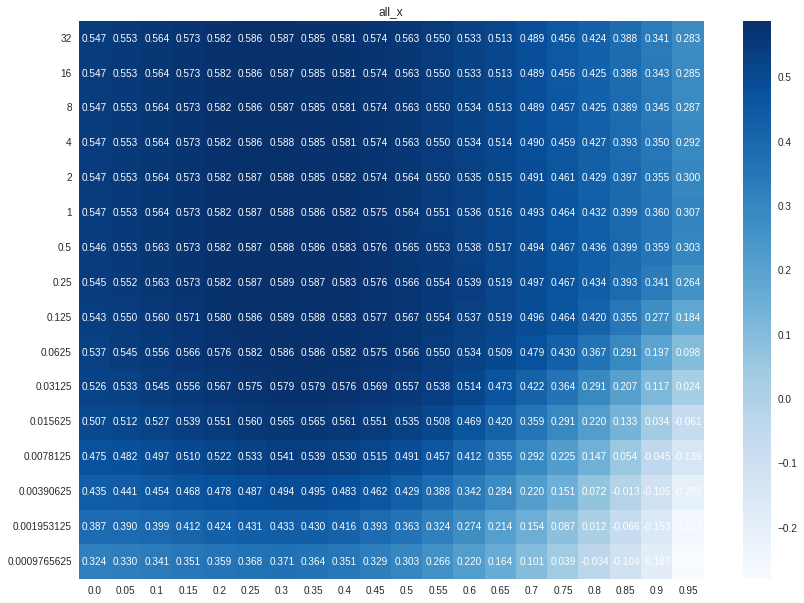

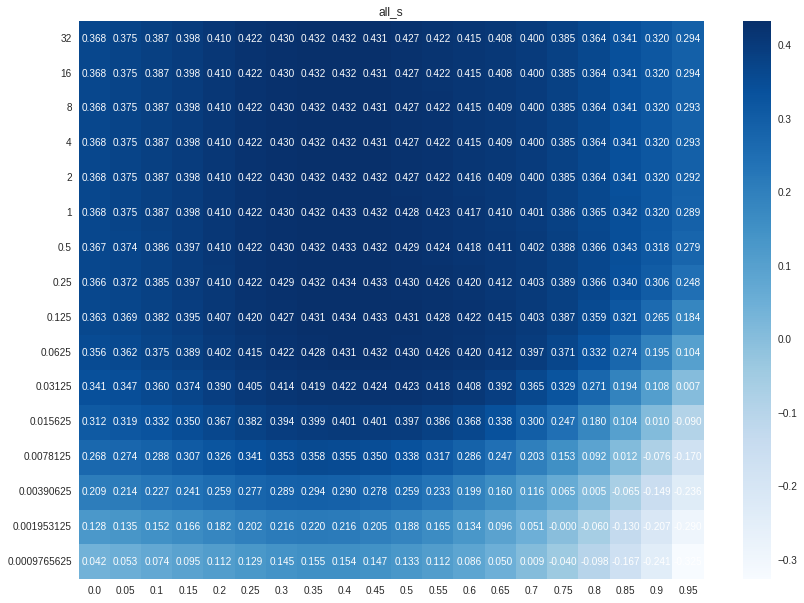

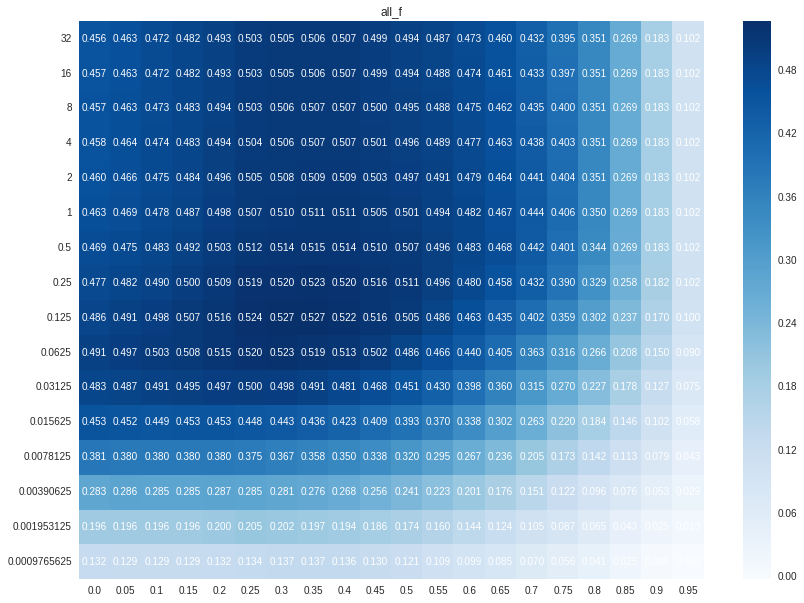

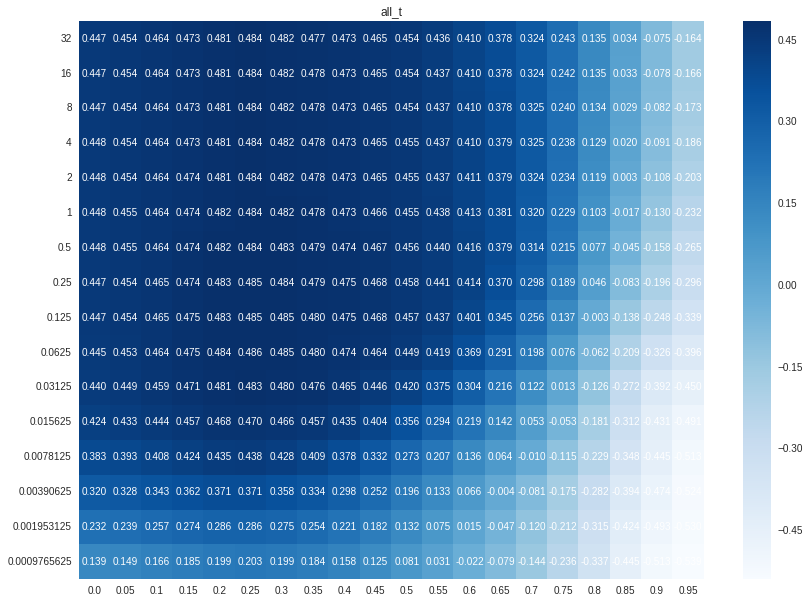

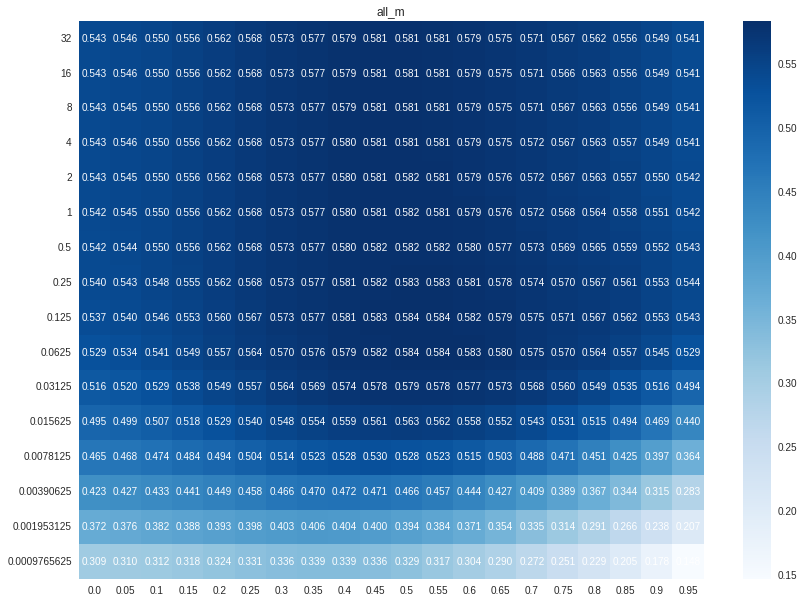

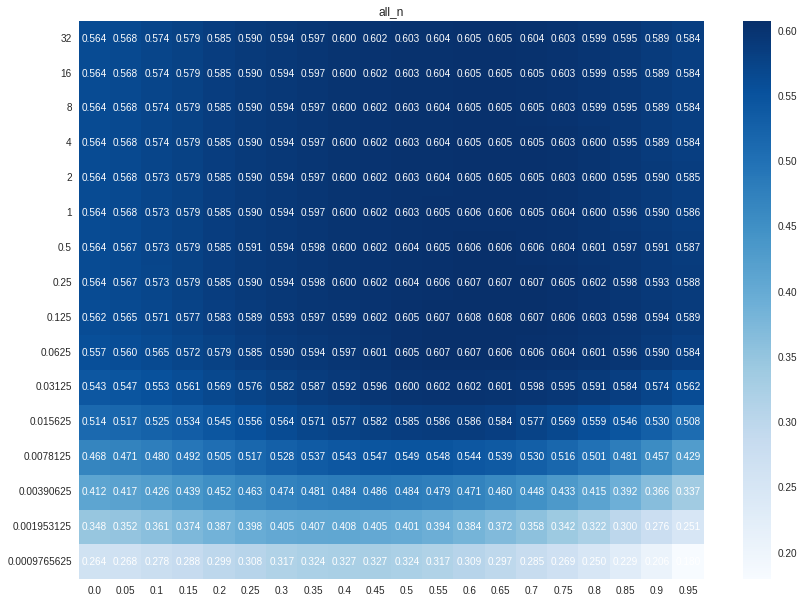

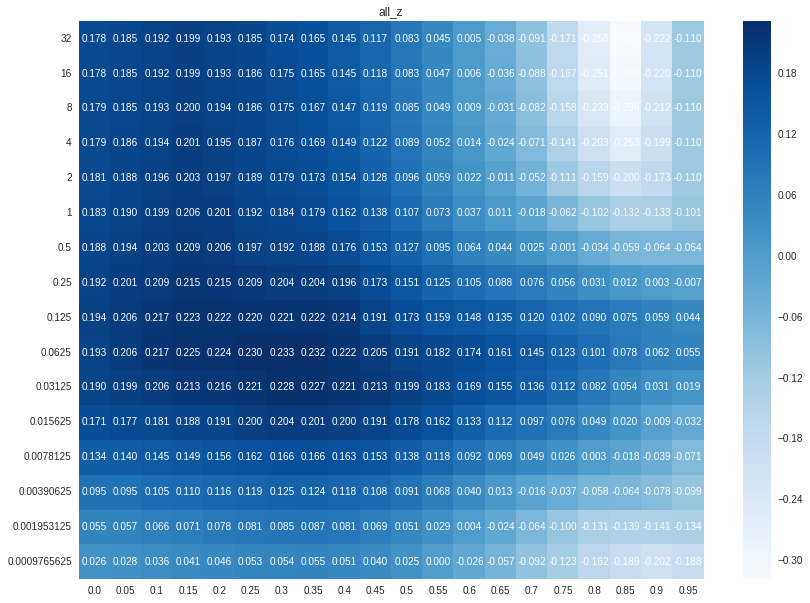

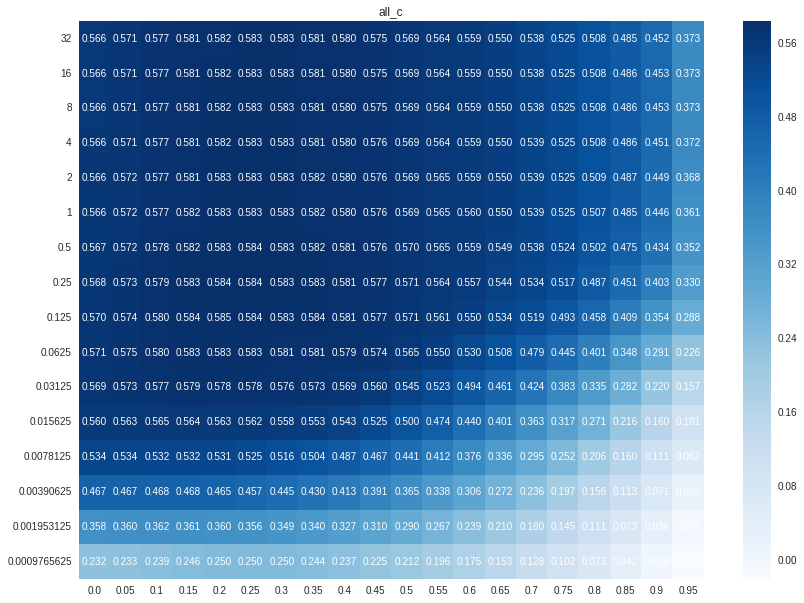

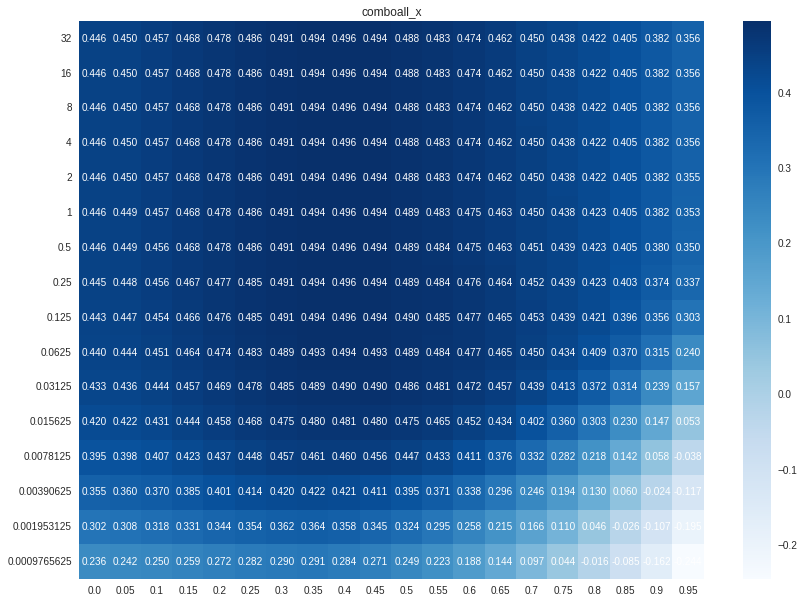

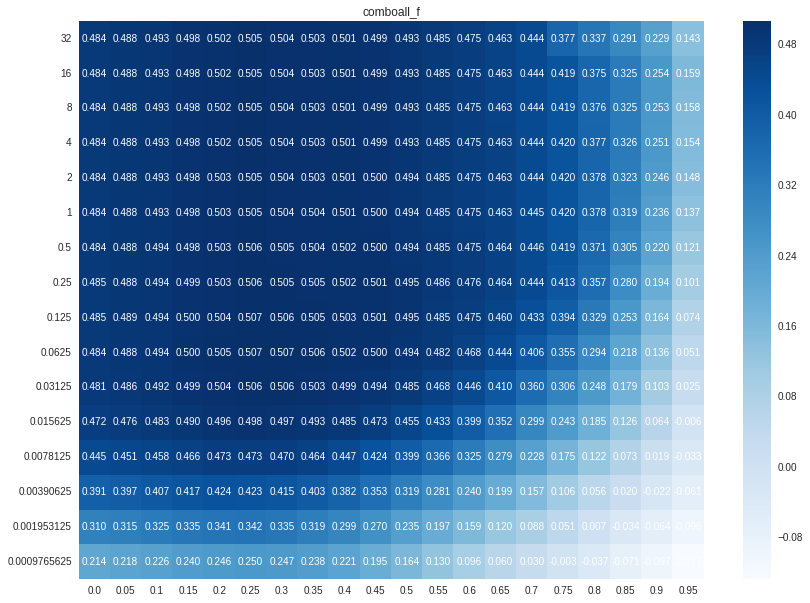

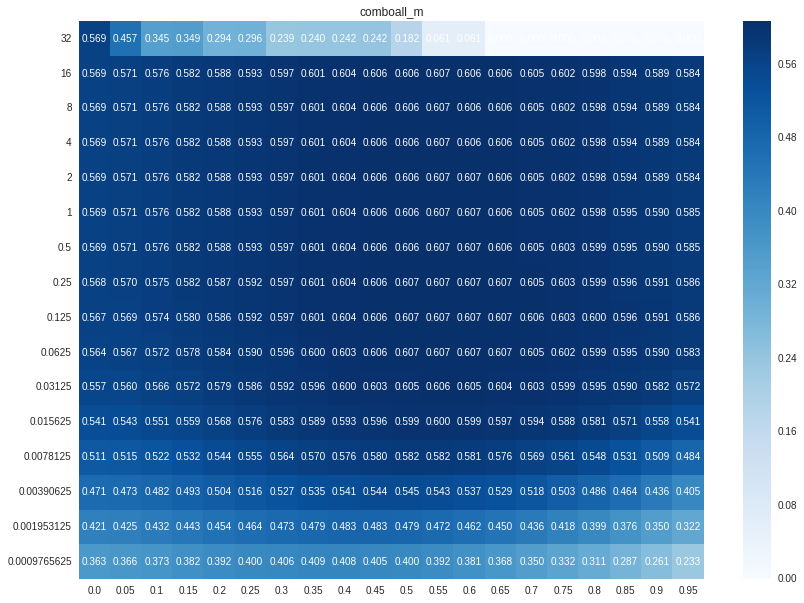

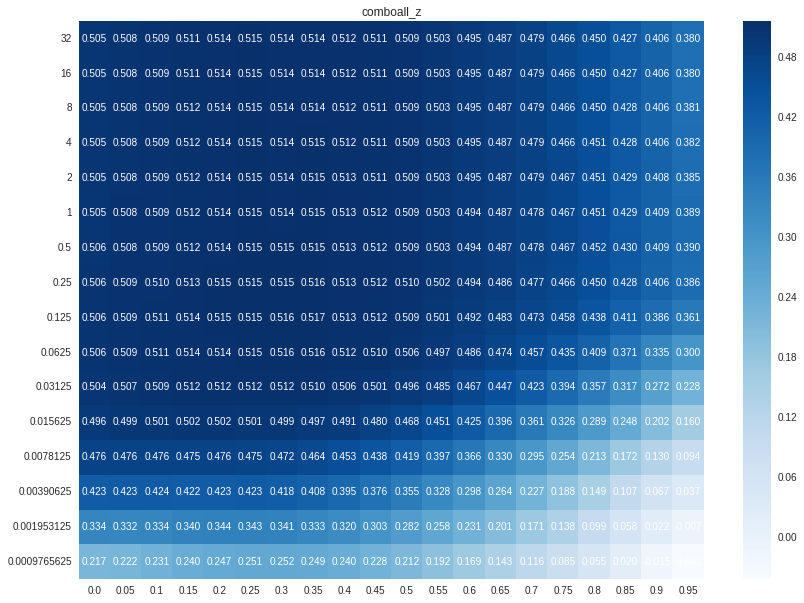

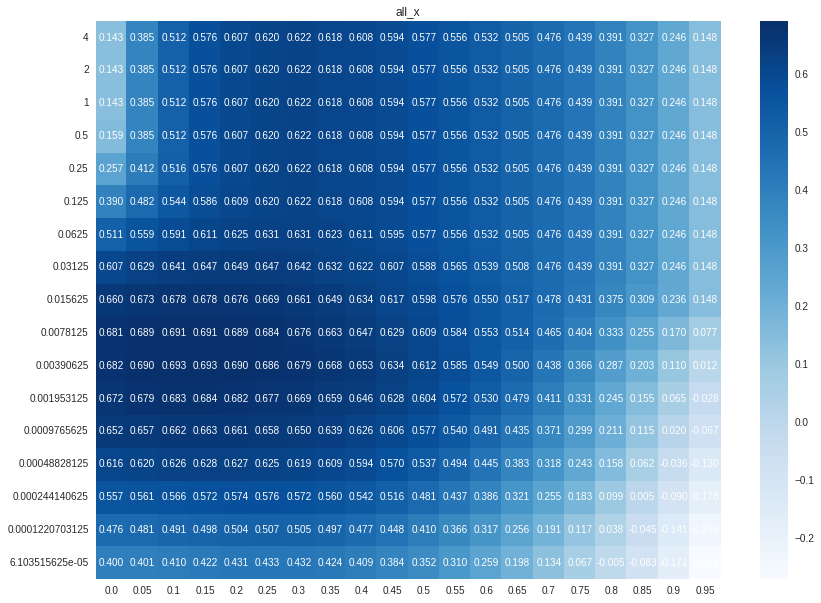

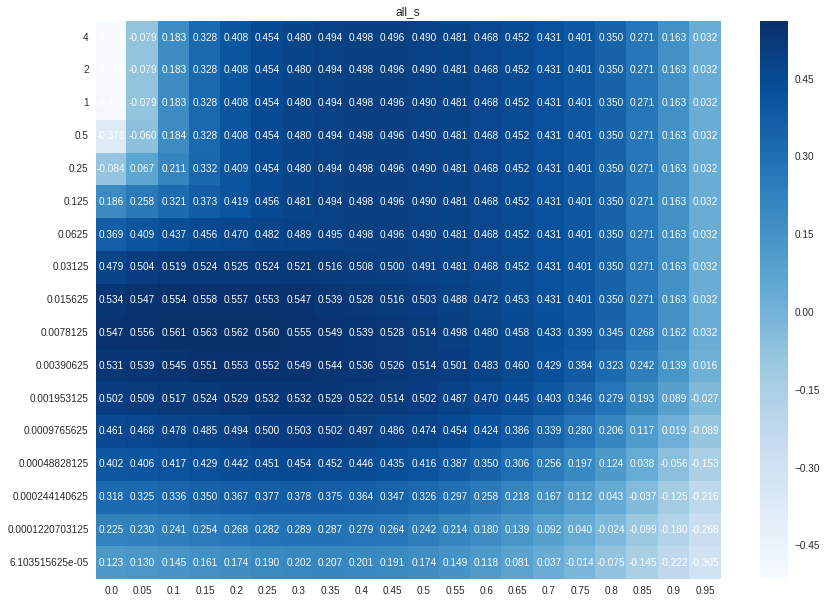

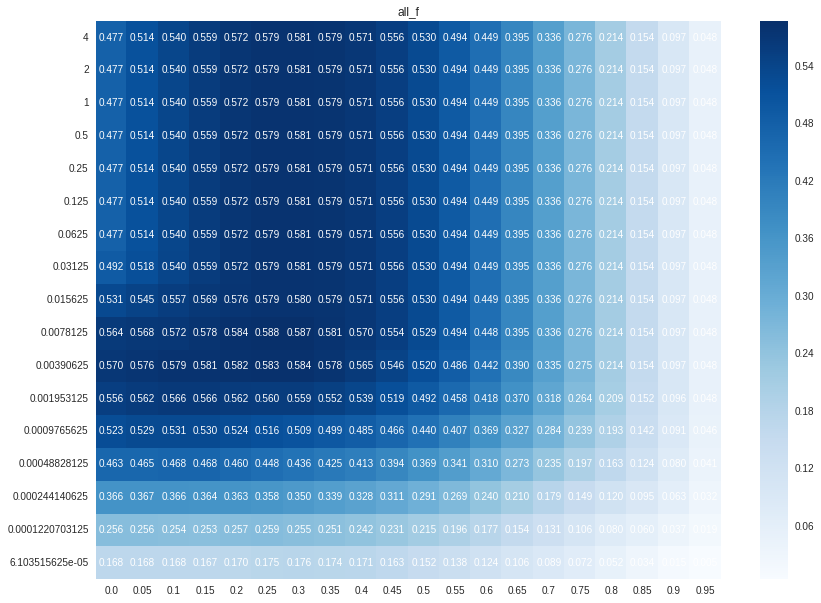

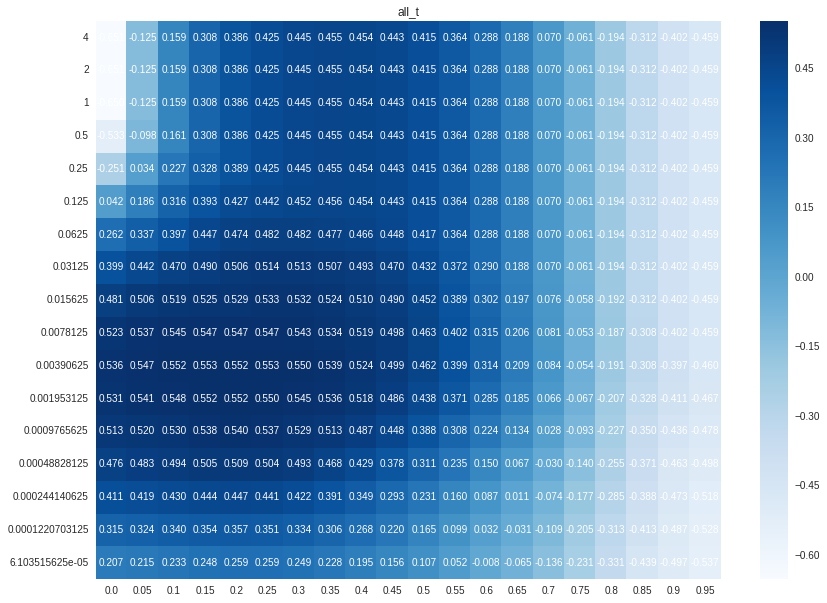

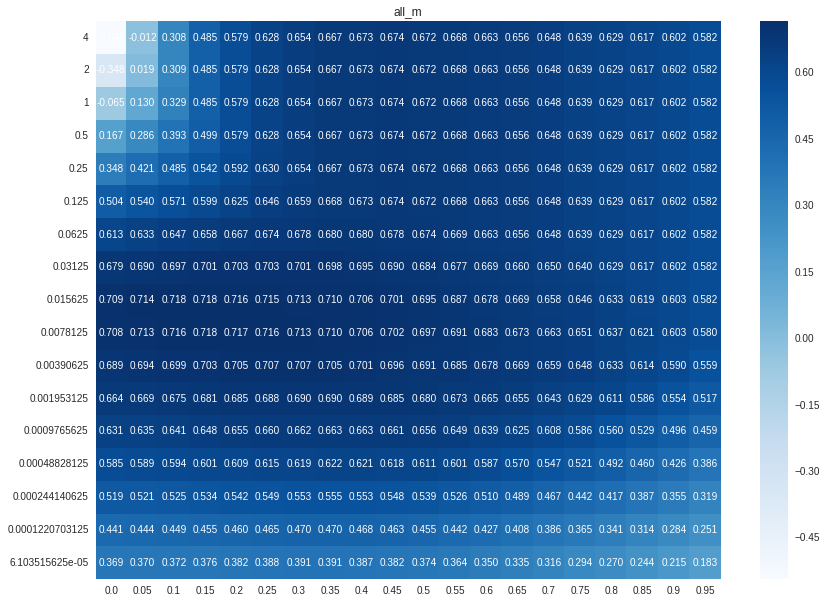

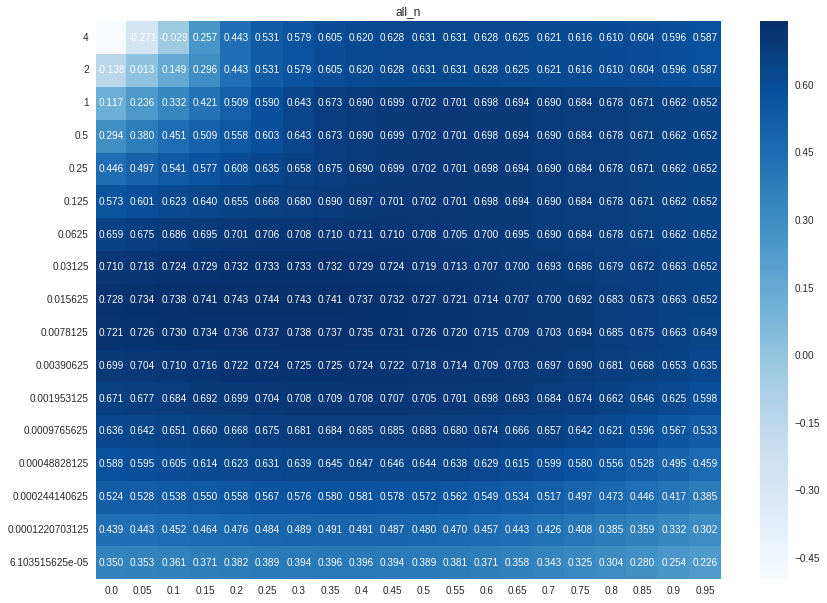

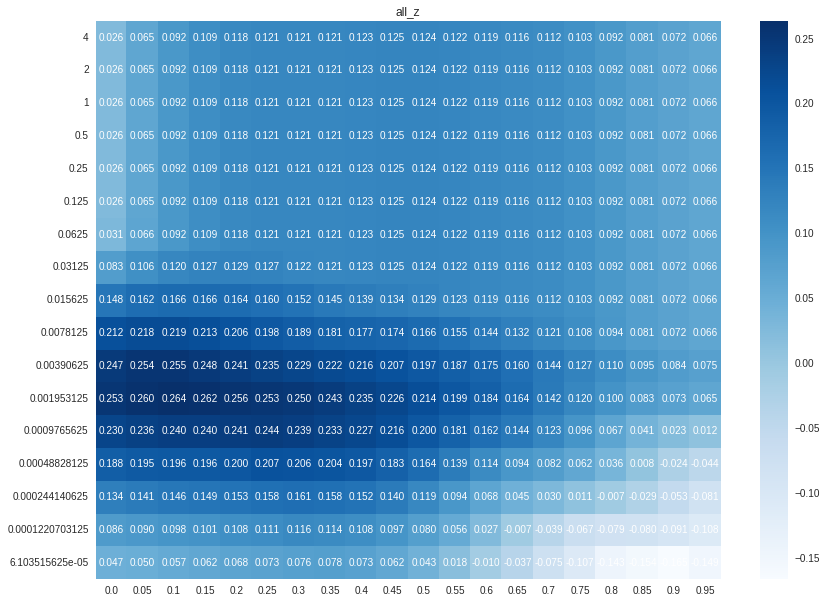

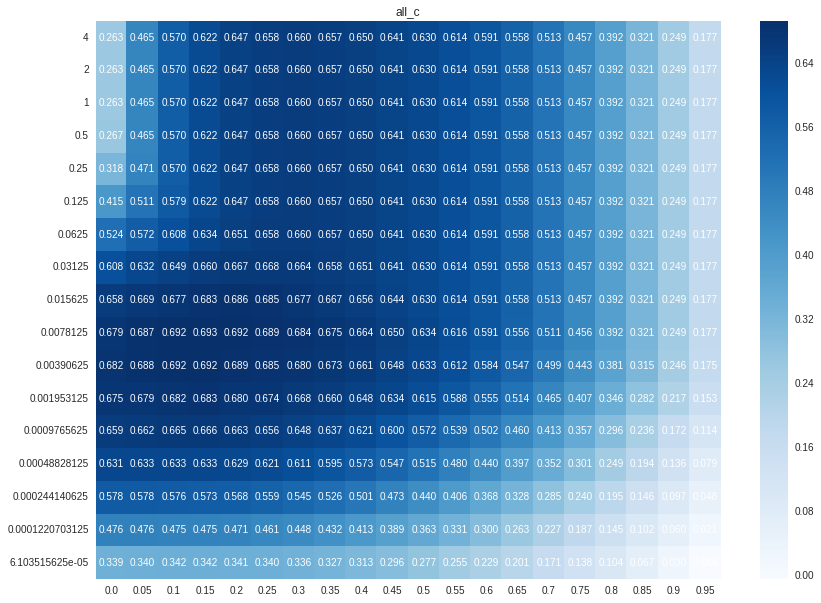

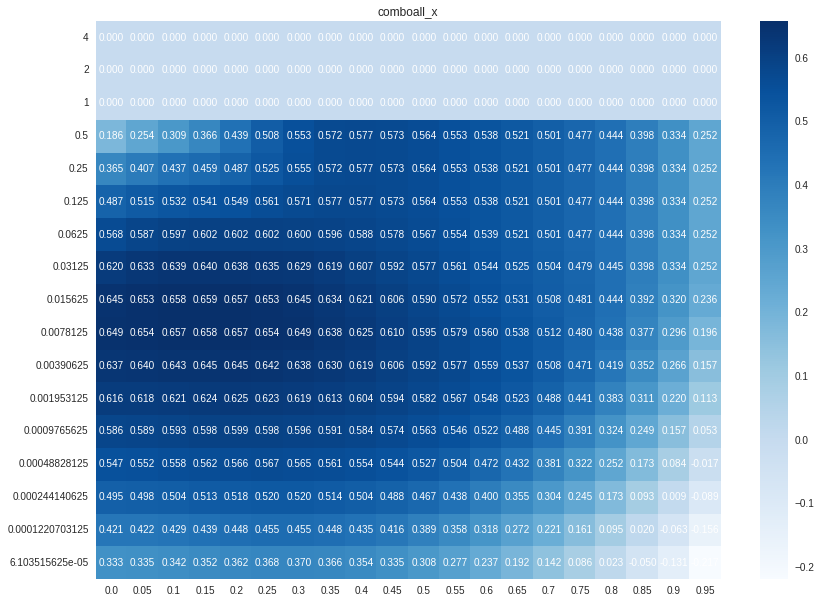

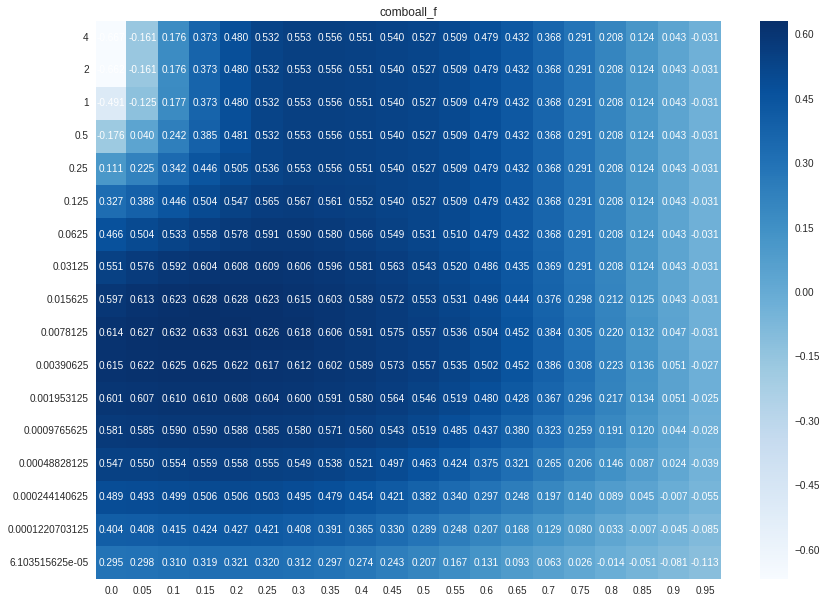

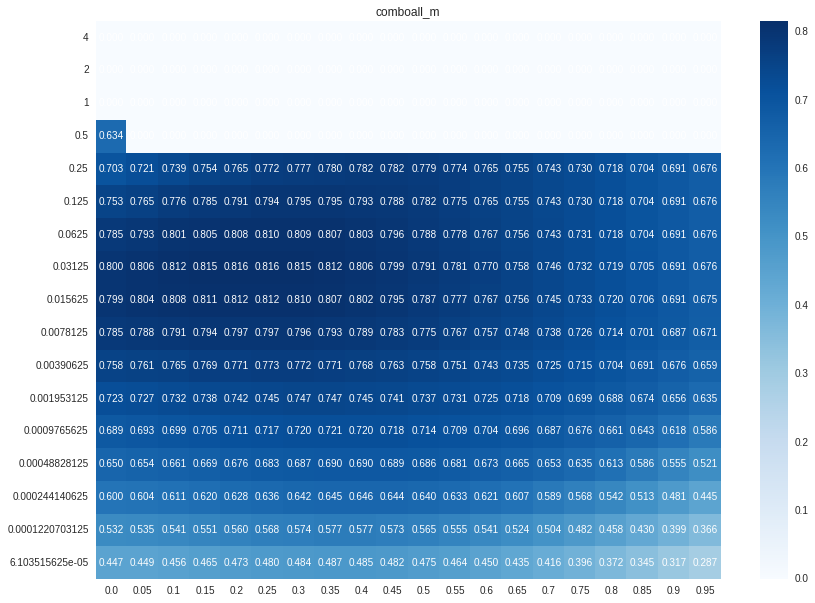

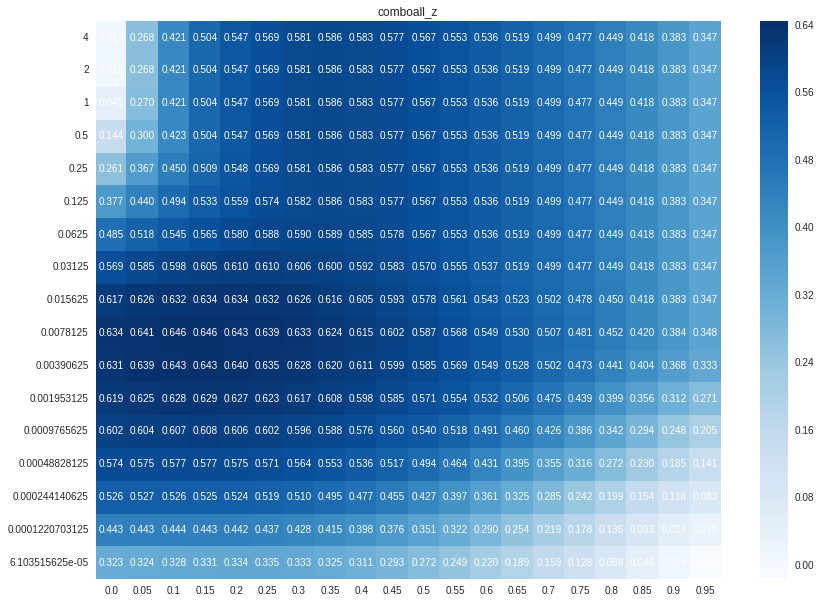

In [6]:
seed=1
for mode in ['linear','poly']:
    for dataset, datasetName, hasWeights, cValues in zip(myDataSets, myDataSetName, myWeights, myCValues[mode]):

        print(mode,datasetName,topFold,end=" ")
        directory = "/home/vxue/data/sort_specificity/rmse_doubleSet/ncv_y/"+str(seed)+"."+mode+"."+datasetName+"."
        plotGridSearch(directory,cValues,epsilon,datasetName)
        

In [6]:
def getBestParam(directory,cvalue,epsilon,datasetName):
    
       
        oneRound = []
        oneRoundValidate = []
        oneRoundTrain = []
        for j in range(10): #outerloop
            myPdArray = pd.read_csv(directory+str(j),delimiter="\s+",skiprows=1)
            
            totSize = len(cvalue)*len(epsilon)
            expandedArray = np.array(myPdArray['test'])
            oneRound.append(np.nan_to_num(np.concatenate([expandedArray, np.array([np.nan]*(totSize - len(expandedArray)))]).reshape(len(cvalue),len(epsilon))))
            
            #oneRound.append(np.array(myPdArray['test']).reshape(25,13))
            
            expandedArray = np.array(myPdArray['validate'])
            oneRoundValidate.append(np.nan_to_num(np.concatenate([expandedArray, np.array([np.nan]*(totSize - len(expandedArray)))]).reshape(len(cvalue),len(epsilon))))
            #oneRoundValidate.append(np.array(myPdArray['validate']).reshape(25,13))
            
            expandedArray = np.array(myPdArray['train'])
            oneRoundTrain.append(np.nan_to_num(np.concatenate([expandedArray, np.array([np.nan]*(totSize - len(expandedArray)))]).reshape(len(cvalue),len(epsilon))))
            
            
        avgScores =np.average(oneRound,axis=0)
        avgScoresValidate= np.average(oneRoundValidate,axis=0)
        avgScoresTrain= np.average(oneRoundTrain,axis=0)
        
        stdScores =np.std(oneRound,axis=0)
        stdScoresValidate= np.std(oneRoundValidate,axis=0)
        stdScoresTrain= np.std(oneRoundTrain,axis=0)

        return((cvalue[argmax(avgScores)//len(epsilon)],         #0 CValue for best averaged test score
                epsilon[argmax(avgScores)%len(epsilon)],         #1 Epsilon for best averaged test score
                max(avgScores.flatten()),                        #2 best averaged test score <- the best args are selected by this loop
                avgScoresValidate.flatten()[argmax(avgScores)],  #3 averaged validation score
                avgScoresTrain.flatten()[argmax(avgScores)],     #4 Averaged Train Score
                stdScores.flatten()[argmax(avgScores)],          #5 std of test score
                stdScoresValidate.flatten()[argmax(avgScores)],  #6 std of validate score
                stdScoresTrain.flatten()[argmax(avgScores)]      #7 std of train score
                
               ))
        
        
        
        

In [7]:
seed=1
averagedScores = []
scoreLabels = []
dictParams = dict()
for mode in ['linear','poly']:
    dictParams[mode]=dict()
    for dataset, datasetName, hasWeights, cValues in zip(myDataSets, myDataSetName, myWeights, myCValues[mode]):
        
        print(mode,datasetName,end=" ")
        directory = "/home/vxue/data/sort_specificity/rmse_doubleSet/ncv_y/"+str(seed)+"."+mode+"."+datasetName+"."
        resultsTupple = getBestParam(directory,cValues,epsilon,datasetName)
        print(resultsTupple[0],resultsTupple[1],"%0.2f"%resultsTupple[2],end=' ')
        print (np.min(cValues) < resultsTupple[0],resultsTupple[0]<np.max(cValues))
        
        
        
        dictParams[mode][datasetName]=(resultsTupple[0],resultsTupple[1])
        averagedScores.append(resultsTupple[2])
        scoreLabels.append(mode+","+datasetName)
        

linear all_x 0.125 0.3 0.59 True True
linear all_s 0.125 0.4 0.43 True True
linear all_f 0.125 0.35 0.53 True True
linear all_t 0.0625 0.25 0.49 True True
linear all_m 0.125 0.5 0.58 True True
linear all_n 0.125 0.6 0.61 True True
linear all_z 0.0625 0.3 0.23 True True
linear all_c 0.125 0.2 0.58 True True
linear comboall_x 0.5 0.4 0.50 True True
linear comboall_f 0.0625 0.3 0.51 True True
linear comboall_m 0.125 0.55 0.61 True True
linear comboall_z 0.125 0.35 0.52 True True
poly all_x 0.00390625 0.1 0.69 True True
poly all_s 0.0078125 0.15 0.56 True True
poly all_f 0.0078125 0.25 0.59 True True
poly all_t 0.00390625 0.25 0.55 True True
poly all_m 0.015625 0.15 0.72 True True
poly all_n 0.015625 0.25 0.74 True True
poly all_z 0.001953125 0.1 0.26 True True
poly all_c 0.0078125 0.15 0.69 True True
poly comboall_x 0.015625 0.15 0.66 True True
poly comboall_f 0.0078125 0.15 0.63 True True
poly comboall_m 0.03125 0.25 0.82 True True
poly comboall_z 0.0078125 0.15 0.65 True True


In [8]:
seed=1
trainRho = []
validateRho = []
trainStd = []
validateStd = []

labelName = []
for dataset, datasetName, hasWeights, cValues in zip(myDataSets, myDataSetName, myWeights, myCValues[mode]):
    for mode in ['linear','poly']:

        print(mode,datasetName, end="\t")
        directory = "/home/vxue/data/sort_specificity/rmse_doubleSet/ncv_y/"+str(seed)+"."+mode+"."+datasetName+"."
        resultsTupple = getBestParam(directory,cValues,epsilon,datasetName)
        print("%0.2f"%resultsTupple[4] ,"\t", "%0.2f"%resultsTupple[3], "\t", len(dataset))
        trainRho.append(resultsTupple[4])
        validateRho.append(resultsTupple[3])
        
        trainStd.append(resultsTupple[7])
        validateStd.append(resultsTupple[6])
        
        labelName.append(mode+"_"+datasetName+"__%i"%len(dataset))
        

linear all_x	0.63 	 0.59 	 2794
poly all_x	0.83 	 0.69 	 2794
linear all_s	0.48 	 0.43 	 3556
poly all_s	0.80 	 0.56 	 3556
linear all_f	0.62 	 0.54 	 1302
poly all_f	0.87 	 0.58 	 1302
linear all_t	0.53 	 0.49 	 3484
poly all_t	0.73 	 0.55 	 3484
linear all_m	0.62 	 0.59 	 3479
poly all_m	0.90 	 0.72 	 3479
linear all_n	0.64 	 0.61 	 3628
poly all_n	0.90 	 0.74 	 3628
linear all_z	0.39 	 0.24 	 1053
poly all_z	0.59 	 0.28 	 1053
linear all_c	0.63 	 0.59 	 2894
poly all_c	0.89 	 0.70 	 2894
linear comboall_x	0.52 	 0.50 	 6350
poly comboall_x	0.84 	 0.66 	 6350
linear comboall_f	0.54 	 0.50 	 4786
poly comboall_f	0.83 	 0.64 	 4786
linear comboall_m	0.62 	 0.61 	 7107
poly comboall_m	0.92 	 0.81 	 7107
linear comboall_z	0.55 	 0.52 	 3947
poly comboall_z	0.84 	 0.64 	 3947


In [9]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        width = rect.get_width()
        yloc = rect.get_y()

        ax.text(width*0.9, yloc,
                '%.2f' % width,
                ha='center', va='bottom')

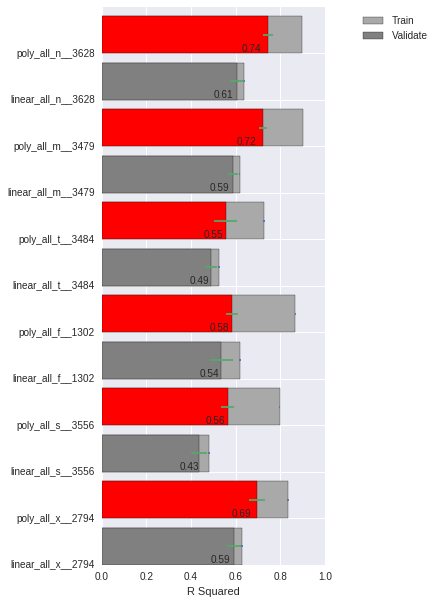

In [10]:
fig,ax = plt.subplots(figsize=(4,10))
barh(range(len(trainRho[0:12])),trainRho[0:12],label='Train',xerr=trainStd[0:12],color='darkgrey')
rects1 = barh(range(len(validateRho[0:12])),validateRho[0:12],color=['grey','red']*3,label='Validate',xerr=validateStd[0:12])
autolabel(rects1)
yticks(range(len(labelName[0:12])),labelName[0:12])
xlabel("R Squared")
legend(bbox_to_anchor=(1.5,1,0,0),loc=1)

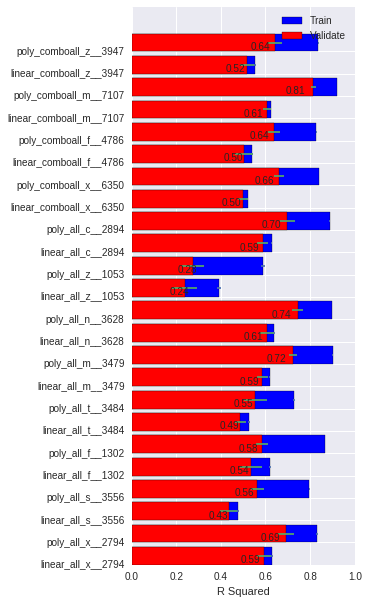

In [11]:
fig,ax = plt.subplots(figsize=(4,10))
barh(range(len(trainRho)),trainRho,label='Train',xerr=trainStd,color='blue')
rects1 = barh(range(len(validateRho)),validateRho,color='red',label='Validate',xerr=validateStd)
autolabel(rects1)
yticks(range(len(labelName)),labelName)
xlabel("R Squared")
legend()

In [13]:
pickle.dump([labelName,trainRho,trainStd],open("/home/vxue/data/sort_specificity/rmse_doubleSet/ncv_y/train.score",'wb'))

In [18]:
pickle.dump([labelName,validateRho,validateStd],open("/home/vxue/data/sort_specificity/rmse_doubleSet/ncv_y/validate.score",'wb'))

In [13]:
dictParams

{'linear': {'all_c': (0.125, 0.20000000000000001),
  'all_f': (0.125, 0.35000000000000003),
  'all_m': (0.125, 0.5),
  'all_n': (0.125, 0.60000000000000009),
  'all_s': (0.125, 0.40000000000000002),
  'all_t': (0.0625, 0.25),
  'all_x': (0.125, 0.30000000000000004),
  'all_z': (0.0625, 0.30000000000000004),
  'comboall_f': (0.0625, 0.30000000000000004),
  'comboall_m': (0.125, 0.55000000000000004),
  'comboall_x': (0.5, 0.40000000000000002),
  'comboall_z': (0.125, 0.35000000000000003)},
 'poly': {'all_c': (0.0078125, 0.15000000000000002),
  'all_f': (0.0078125, 0.25),
  'all_m': (0.015625, 0.15000000000000002),
  'all_n': (0.015625, 0.25),
  'all_s': (0.0078125, 0.15000000000000002),
  'all_t': (0.00390625, 0.25),
  'all_x': (0.00390625, 0.10000000000000001),
  'all_z': (0.001953125, 0.10000000000000001),
  'comboall_f': (0.0078125, 0.15000000000000002),
  'comboall_m': (0.03125, 0.25),
  'comboall_x': (0.015625, 0.15000000000000002),
  'comboall_z': (0.0078125, 0.15000000000000002)}}

In [14]:
for mode in ['linear','poly']:
    for dataset, datasetName, hasWeights, cValues in zip(myDataSets, myDataSetName, myWeights, myCValues[mode]):
        paramC,paramEpsilon = dictParams[mode][datasetName]
        
        print(mode,datasetName,len(dataset),paramC,paramEpsilon)

linear all_x 2794 0.125 0.3
linear all_s 3556 0.125 0.4
linear all_f 1302 0.125 0.35
linear all_t 3484 0.0625 0.25
linear all_m 3479 0.125 0.5
linear all_n 3628 0.125 0.6
linear all_z 1053 0.0625 0.3
linear all_c 2894 0.125 0.2
linear comboall_x 6350 0.5 0.4
linear comboall_f 4786 0.0625 0.3
linear comboall_m 7107 0.125 0.55
linear comboall_z 3947 0.125 0.35
poly all_x 2794 0.00390625 0.1
poly all_s 3556 0.0078125 0.15
poly all_f 1302 0.0078125 0.25
poly all_t 3484 0.00390625 0.25
poly all_m 3479 0.015625 0.15
poly all_n 3628 0.015625 0.25
poly all_z 1053 0.001953125 0.1
poly all_c 2894 0.0078125 0.15
poly comboall_x 6350 0.015625 0.15
poly comboall_f 4786 0.0078125 0.15
poly comboall_m 7107 0.03125 0.25
poly comboall_z 3947 0.0078125 0.15


In [15]:
pickle.dump(dictParams,open("/home/vxue/data/sort_specificity/rmse_doubleSet/ncv_y/bestParams.pickle",'wb'))